In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.infering import EntityRelationInferer
from src.processing.dialogre_processing import DialogREDatasetTransformer
from src.paths import LOCAL_MODELS_PATH, LOCAL_PROCESSED_DATA_PATH, LOCAL_RAW_DATA_PATH

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.io as pio
from tqdm import tqdm

tqdm.pandas()

dt = DialogREDatasetTransformer(LOCAL_RAW_DATA_PATH / 'dialog-re')
df = dt.load_data_to_dataframe().explode('Relations')

bert_config_file = LOCAL_MODELS_PATH / "downloaded/bert-base/bert_config.json"
vocab_file = LOCAL_MODELS_PATH / "downloaded/bert-base/vocab.txt"
model_path=LOCAL_MODELS_PATH / "fine-tuned/bert-base-dialog-re/Unfrozen/24bs-1cls-3em5lr-20ep/model_best.pt"
relation_label_dict = LOCAL_RAW_DATA_PATH / 'dialog-re/relation_label_dict.json'
relation_type_count = 36
T2 = 0.32

inferer = EntityRelationInferer(
    bert_config_file=bert_config_file, 
    vocab_file=vocab_file, 
    model_path=model_path, 
    relation_type_count=relation_type_count, 
    relation_label_dict=relation_label_dict,
    T2=T2)


inferer.device


/home/ubuntu/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-07-18 09:21:43.721814: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ubuntu/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [3]:
df['pred'] = df.progress_apply(
    lambda row:
        inferer.infer_relations(
            dialogue=' '.join(row['Dialogue']),
            entity1=row['Relations']['x'],
            entity2=row['Relations']['y']),
        axis=1
        )

100%|██████████| 9749/9749 [02:58<00:00, 54.72it/s]


In [4]:
# Filter relevant data for metrics
mask = df.Origin == 'test'
tmp = df[mask]

# Extract rid relation ids for comparison
ground_truth = tmp.Relations.apply(lambda x: x['rid'][0])
predictions = tmp.pred.apply(lambda x: x[0])

# Compute accuracy
accuracy = accuracy_score(ground_truth, predictions)

# Compute precision, recall, f1-score per label and overview
classificationRep = classification_report(ground_truth, predictions)

# Print the results
print('Accuracy: \n', accuracy)
print('Classification Report: \n', classificationRep)


Accuracy: 
 0.5861141011840689
Classification Report: 
               precision    recall  f1-score   support

           1       0.44      0.34      0.38       127
           2       0.00      0.00      0.00        47
           3       0.00      0.00      0.00        32
           4       0.22      0.07      0.11        28
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00        17
           8       0.00      0.00      0.00         6
           9       0.52      0.81      0.64       109
          10       0.53      0.62      0.57       130
          11       0.00      0.00      0.00        12
          12       0.31      0.50      0.38        24
          13       0.45      0.20      0.27        46
          14       0.88      0.25      0.39        28
          15       0.50      0.10      0.17        48
          16       0.49      0.66      0.56        58
          17       0.38  

/home/ubuntu/miniconda3/envs/relnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/relnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/miniconda3/envs/relnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

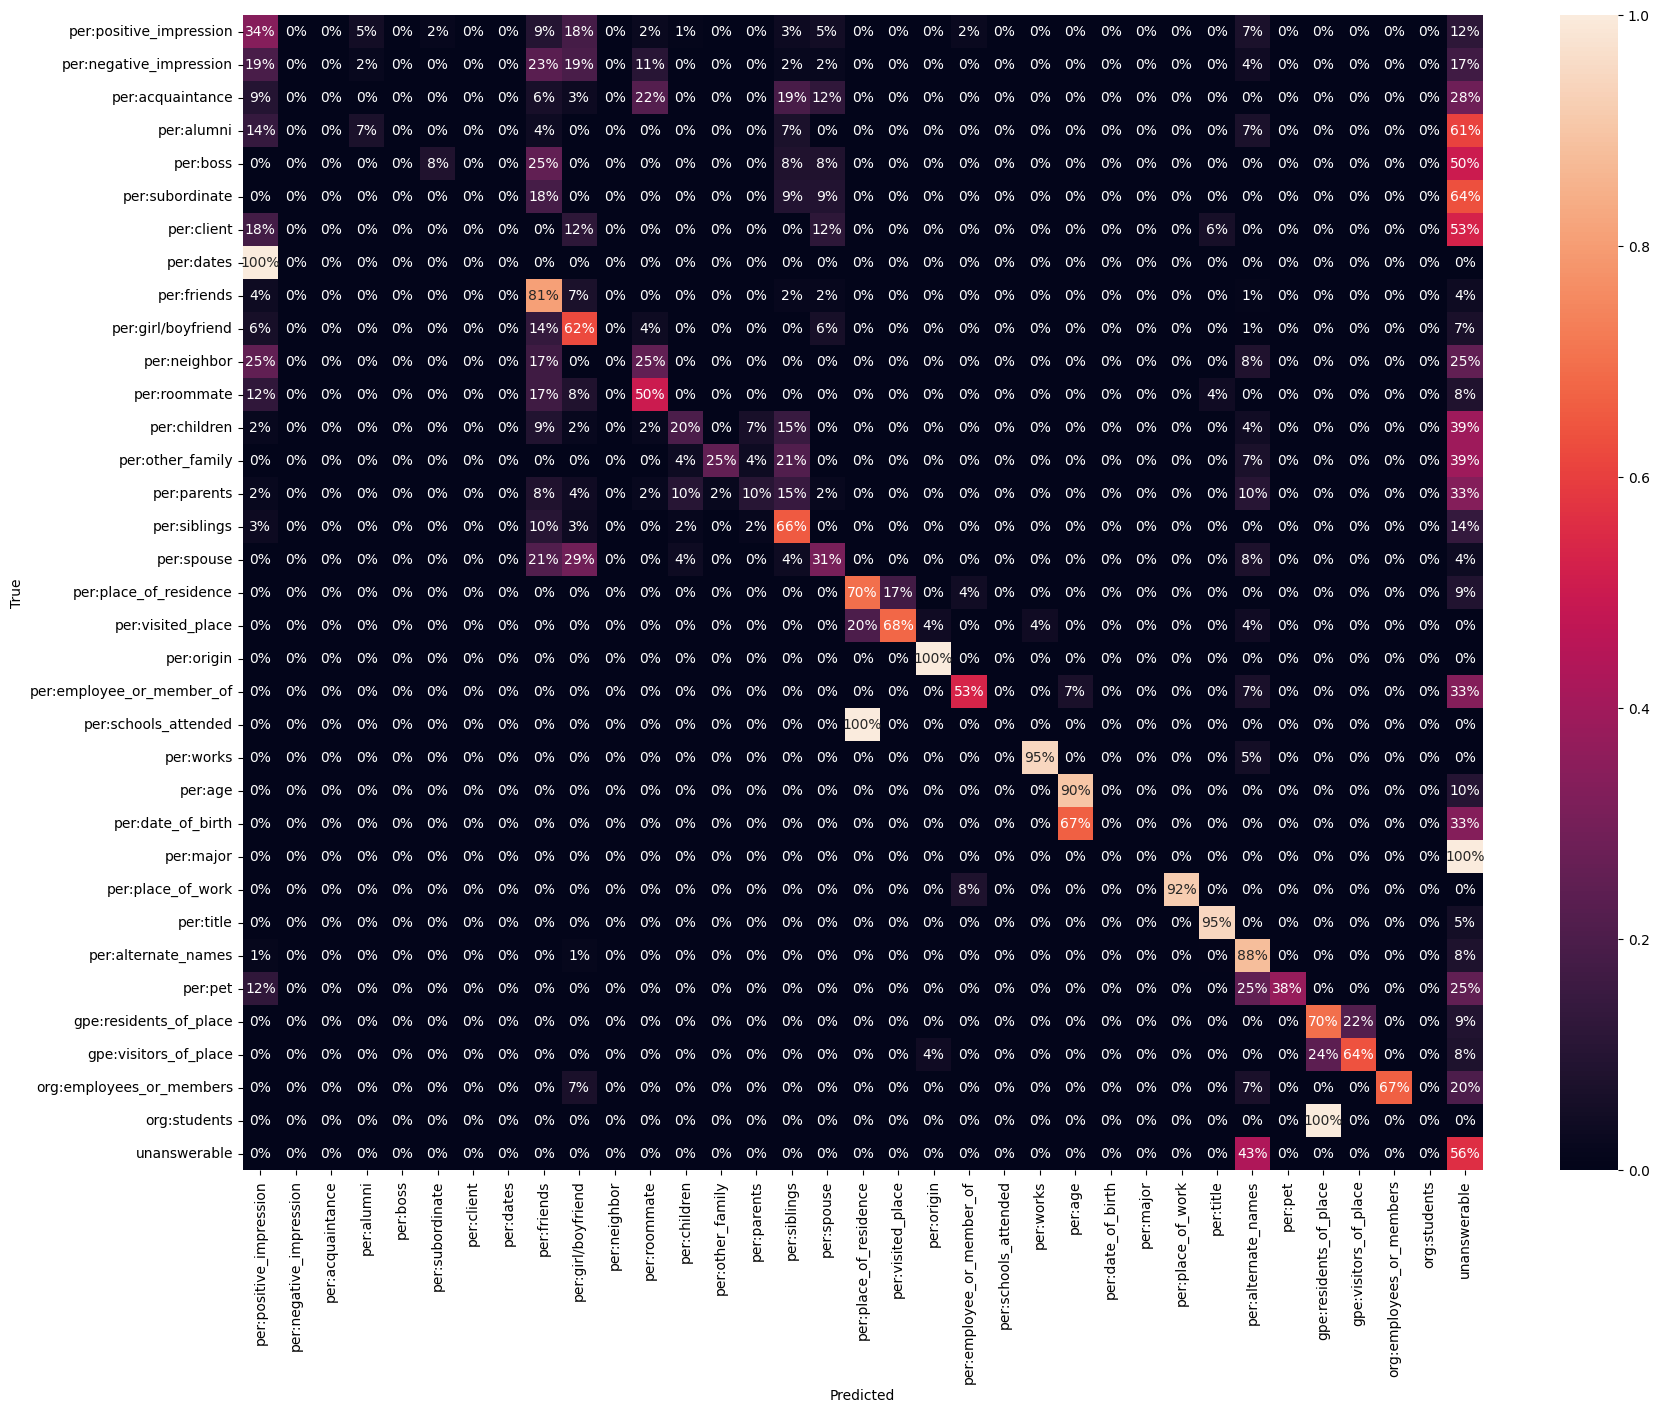

In [13]:


# Convert your data into the right format
mlb = MultiLabelBinarizer()
ground_truth_mlb = mlb.fit_transform(ground_truth.apply(lambda x: [x]))
predictions_mlb = mlb.transform(predictions.apply(lambda x: [x]))

# Transform the multilabel problem into multi-class
ground_truth_mc = ground_truth_mlb.argmax(axis=1)
predictions_mc = predictions_mlb.argmax(axis=1)

# Compute the confusion matrix
cm = confusion_matrix(ground_truth_mc, predictions_mc, normalize='true')

# Use Seaborn to plot the confusion matrix
readable_classes = [inferer._convert_rid_to_label(c) for c in mlb.classes_]

# Create the heatmap
plt.figure(figsize=(20, 15))
ax = sns.heatmap(cm, annot=True, fmt='.0%', xticklabels=readable_classes, yticklabels=readable_classes)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Create x and y coordinates
x = readable_classes
y = readable_classes[::-1]  # Reverse the y labels

# Reverse the order of lists in z
z = cm[::-1]


In [24]:
import plotly.graph_objects as go

hovertext = [['True: {}<br>Predicted: {}<br>Predicted Ratio: {:.1f}%'.format(y[i], x[j], 100*item)
              for j, item in enumerate(sublist)] for i, sublist in enumerate(z)]

heatmap = go.Figure(data=go.Heatmap(
    z=z,
    x=x,
    y=y,
    hoverinfo='text',
    text=hovertext,
    colorscale='Viridis'
))

heatmap.update_layout(
    title_text='<i><b>Confusion Matrix:</b> BERT Classifier on DialogRE</i>',
    xaxis = dict(title='Predicted label', tickangle=-45),
    yaxis = dict(title='True label'),
    height=1000,
)
heatmap.show()


In [26]:
pio.write_html(heatmap, 'dialogre-bert-cm-performance.html')